# Dog Breed Classifier

---
Develop an algorithm that could be used as part of a mobile or web app to process real-world, user-supplied images. At the end of this project, the algorithm will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

### Main Steps

* [Step 0](#step0): Import datasets
* [Step 1](#step1): Detect humans
* [Step 2](#step2): Detect dogs
* [Step 3](#step3): Create a CNN to classify dog breeds (from scratch)
* [Step 4](#step4): Use a CNN to classify dog breeds (using transfer learning)
* [Step 5](#step5): Create a CNN to classify dog breeds (using transfer learning)
* [Step 6](#step6): Write algorithm
* [Step 7](#step7): Test algorithm
* [Step 8](#step8): Overlay dog ears on detected human heads
* [Step 9](#step9): Turn the algorithm into a web app

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

Use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

Number of faces detected: 1


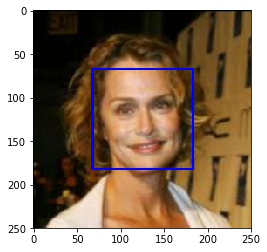

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

__Question 1:__ Test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

ct_h1 = sum([1 for img in human_files_short if face_detector(img) == True])
ct_h2 = sum([1 for img in dog_files_short if face_detector(img) == True])
print("{0:.0f}%".format(ct_h1), "of the first 100 images in human_files have a detected human face")  
print("{0:.0f}%".format(ct_h2), "of the first 100 images in dog_files have a detected human face") 

98% of the first 100 images in human_files have a detected human face
11% of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ It's not a reasonable expectation to pose on the user. This dedector requires clear view of a face because it leverages a machine learning approach where features of face and non-face are extracted and used for detection. Inability to extract these features, which is the case in an image without a clearly presented face, the detection will return false classifications. One way may address this limitation is to use deep learning (CNN) where the "features" are not listed explicitly, like how we detect dogs below.  

---
<a id='step2'></a>
## Step 2: Detect Dogs

We use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input` (check the code [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py)).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

Looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

In [9]:
# returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

__Question 3:__ Test the performance of the `dog_detector` function. 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
ct_d1 = sum([1 for img in human_files_short if dog_detector(img) == True])
ct_d2 = sum([1 for img in dog_files_short if dog_detector(img) == True])
print("{0:.0f}%".format(ct_d1), "% of the first 100 images in human_files have a detected dog")  
print("{0:.0f}%".format(ct_d2), "% of the first 100 images in dog_files have a detected dog") 

1% % of the first 100 images in human_files have a detected dog
100% % of the first 100 images in dog_files have a detected dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# pre-process the data for Keras
train_datagen = image.ImageDataGenerator(
        rotation_range=25,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dogImages/train',  
        target_size=(224, 224),  
        batch_size=64)

validation_generator = test_datagen.flow_from_directory(
        'dogImages/valid', 
        target_size=(224, 224), 
        batch_size=64)

test_tensors = paths_to_tensor(test_files).astype('float32')/255

Found 6680 images belonging to 133 classes.


  1%|▏         | 11/836 [00:00<00:07, 107.82it/s]

Found 835 images belonging to 133 classes.


100%|██████████| 836/836 [00:12<00:00, 67.02it/s]


### Model Architecture

Create a CNN to classify dog breed. 
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.

__Answer:__ The model architecture is a trimmed-down version of AlexNet -
[(CS231n Convolutional Neural Networks for Visual Recognition)](http://cs231n.github.io/convolutional-networks/)
* Conv2D: convolutional layers learn simple features first, such as edges, then learn more abstract features as it goes deeper. Therefore, the number of filters increase and the size of them decrease as layers are added. 
* BatchNormalization: batch normalization is a technique for improving the performance and stability of neural networks. The idea is to normalize the layer inputs such that they have a mean of zero and variance of one, much like how we standardize the inputs to networks
* MaxPooling2D: down-sampling to reduce computational overhead for the next layers of the network; it also helps to mitigate over-fitting
* Dropout: dropout is a common technique to regularize CNNs.
* Dense: fully-connected layer where the last one being the output layer.

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

def create_model():
    model = Sequential()  
    
    model.add(Conv2D(64, (11, 11), strides=(4, 4), padding="same", kernel_initializer ='he_normal', input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    #model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (7, 7), strides=(1, 1), padding="same", kernel_initializer ='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2)) 
    #model.add(Dropout(0.1))
    
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same", kernel_initializer ='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2)) 
    #model.add(Dropout(0.1))
                     
    model.add(Flatten())    
    model.add(Dense(1000, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    #model.add(GlobalAveragePooling2D(input_shape=(None, 28, 28, 512)))
    
    model.add(Dense(133, activation='softmax'))
    return model

dogmodel = create_model()
dogmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 64)        23296     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
activation_50 (Activation)   (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 128)       512       
_________________________________________________________________
activation_51 (Activation)   (None, 27, 27, 128)       0         
__________

### Compile the Model

In [ ]:
dogmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Use model checkpointing to save the model that attains the best validation loss.

In [ ]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)

dogmodel.fit_generator(
        train_generator,
        steps_per_epoch=30,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=6, 
        callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [13]:
dogmodel.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [14]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(dogmodel.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.8182%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we can train a CNN using transfer learning.

### Obtain Bottleneck Features

In [15]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [16]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [17]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [18]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.5742%


### Predict Dog Breed with the Model

In [19]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Below are pre-computed features for networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such: `Dog{network}Data.npz` where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

### Obtain Bottleneck Features

Extract the bottleneck features corresponding to the train, test, and validation sets:

In [20]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ (Note from Udacity DL class) If the new data set is small and similar to the original training data:

* slice off the end of the neural network
* add a new fully connected layer that matches the number of classes in the new data set
* randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
* train the network to update the weights of the new fully connected layer

To avoid overfitting on the small data set, the weights of the original network will be held constant rather than re-training the weights.

Since the data sets are similar, images from each data set will have similar higher level features. Therefore most or all of the pre-trained neural network layers already contain relevant information about the new data set and should be kept.

The model below uses the the pre-trained Resnet50 model as a fixed feature extractor, where the last convolutional output of Resnet50 is fed as input to our model. Add a global average pooling layer, a dense layer similar to step 3 and a fully connected layer which contains one node for each dog category and is equipped with a softmax.

In [21]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(1024, kernel_initializer='he_normal'))
Resnet50_model.add(BatchNormalization())
Resnet50_model.add(Activation('relu'))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_54 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               136325    
Total params: 2,238,597.0
Trainable params: 2,236,549.0
Non-trainable params: 2,048.0
_________________________________________________________________


### Compile the Model

In [ ]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=25, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [22]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

In [23]:
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.0574%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model. 

In [24]:
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return top 3 dog breeds that are predicted by the model
    ind = np.argsort(predicted_vector[0])[::-1][:3]
    return [(dog_names[i], "{0:.2f}%".format(predicted_vector[0][i] * 100)) for i in ind]

---
<a id='step6'></a>
## Step 6: Write Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You look like ... 
 ('Akita', '30.82%') 
 ('Silky_terrier', '23.74%') 
 ('American_foxhound', '5.38%')


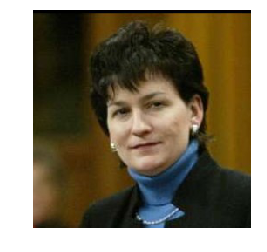

This cutie is ... 
 ('Glen_of_imaal_terrier', '91.60%') 
 ('Affenpinscher', '3.34%') 
 ('Bouvier_des_flandres', '1.97%')


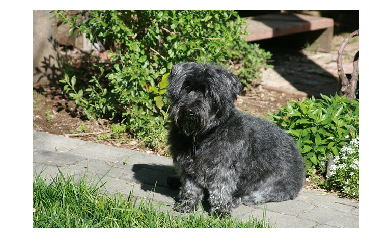

In [25]:
def dog_breed (image):
    img = cv2.imread(image)
    if dog_detector(image) == True:
        dog = Resnet50_predict_breed(image)
        #cv2.putText(img, 'This cuttie is a %s !'%(dog),(50,50), cv2.FONT_ITALIC , 0.5,(200,255,255),2,cv2.LINE_AA)
        print ('This cutie is ...', '\n', dog[0], '\n', dog[1], '\n', dog[2])
    elif face_detector(image) == True:
        dog = Resnet50_predict_breed(image)
        #cv2.putText(img, 'You look like a %s !'%(dog),(50,50), cv2.FONT_ITALIC , 0.5,(200,255,255),2,cv2.LINE_AA)
        print ('You look like ...', '\n', dog[0], '\n', dog[1], '\n', dog[2])
    else:
        #cv2.putText(img, 'No human or dog!',(50,50), cv2.FONT_ITALIC , 0.5,(200,255,255),2,cv2.LINE_AA)
        print ('No human or dog!')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

        
# test
dog_breed(human_files[111])
dog_breed(train_files[111])

---
<a id='step7'></a>
## Step 7: Test Algorithm
 
__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is better than I expected, it classified various pictures of my dog correctly.
A more robust algorithm should be able to:
1. Detect and classify multiple objects (humans and dogs) in an image (e.g. using heatmap [(implemented here for another project)](https://github.com/LuLi0077/SDC/tree/master/Vehicle_Detection) or [YOLO/SSD](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf) approach).
2. Improve `dog_detector()` and `face_detector()` accuracy through data augmentation or bigger/deeper networks.
3. Explore transferability of features from each layer of `Resnet50_model` and improve performance ([How transferable are features in deep neural networks?](https://arxiv.org/pdf/1411.1792.pdf)).

You look like ... 
 ('Bull_terrier', '33.86%') 
 ('English_springer_spaniel', '24.82%') 
 ('Beagle', '10.48%')


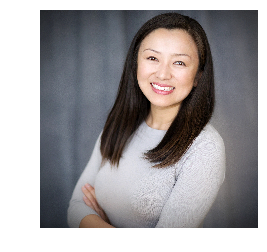

You look like ... 
 ('Havanese', '55.55%') 
 ('Silky_terrier', '11.31%') 
 ('Bearded_collie', '9.25%')


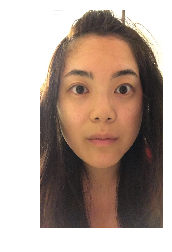

You look like ... 
 ('American_foxhound', '39.83%') 
 ('Bull_terrier', '18.70%') 
 ('Xoloitzcuintli', '8.59%')


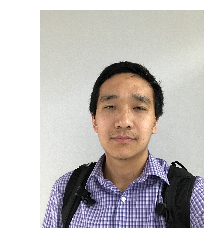

You look like ... 
 ('Maltese', '86.41%') 
 ('Bull_terrier', '6.59%') 
 ('Pointer', '2.49%')


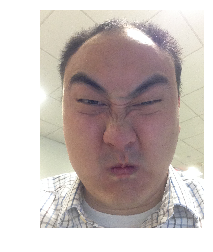

You look like ... 
 ('Silky_terrier', '97.13%') 
 ('German_shepherd_dog', '0.55%') 
 ('Lowchen', '0.30%')


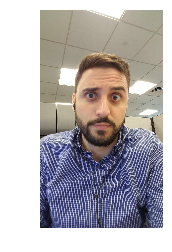

This cutie is ... 
 ('Boston_terrier', '100.00%') 
 ('French_bulldog', '0.00%') 
 ('Chihuahua', '0.00%')


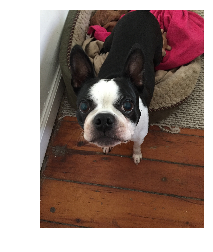

This cutie is ... 
 ('Bulldog', '95.73%') 
 ('American_staffordshire_terrier', '3.54%') 
 ('Chinese_shar-pei', '0.40%')


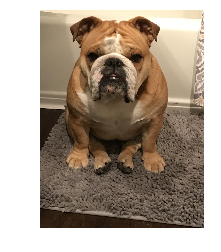

This cutie is ... 
 ('Boston_terrier', '95.82%') 
 ('French_bulldog', '4.15%') 
 ('Basenji', '0.03%')


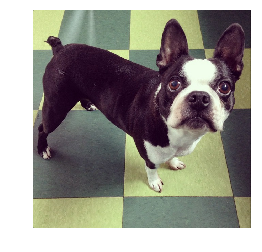

This cutie is ... 
 ('Boston_terrier', '78.50%') 
 ('Great_dane', '18.89%') 
 ('American_staffordshire_terrier', '1.79%')


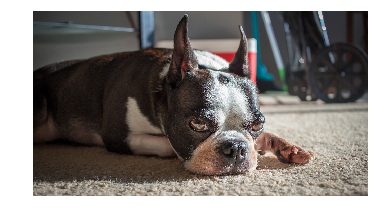

In [26]:
dog_breed('images/image1.JPG')
dog_breed('images/image2.JPG')
dog_breed('images/image3.JPG')
dog_breed('images/image4.JPG')
dog_breed('images/image5.JPG')
dog_breed('images/image6.JPG')
dog_breed('images/image7.JPG')
dog_breed('images/image8.png')
dog_breed('images/image9.JPG')

---
<a id='step8'></a>
## Step 8: Overlay Dog Ears on Detected Human Heads

Overlay a Snapchat-like filter with dog ears on detected human heads. Some nice tutorials for facial keypoints detection exist [here](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial).

---
<a id='step9'></a>
## Step 9: Turn the Algorithm into a Web App

Turn it into a web app using [Flask](http://flask.pocoo.org/) or [web.py](http://webpy.org/docs/0.3/tutorial)! 